In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from jax.scipy.stats import multivariate_normal
from jax.experimental import optimizers
from jax.experimental import stax
from jax.lax import stop_gradient
from matplotlib import animation
from tqdm.notebook import trange
from IPython.display import HTML
import matplotlib.pyplot as plt
from functools import partial
from dm_control import suite
import jax.numpy as jnp
import numpy as np
import matplotlib
import copy
import jax

method_jit = partial(jax.jit, static_argnums=(0,))  # jit that works with class methods


import ipdb


# notes
- **std options:** if std learned, save stds along with actions and use to compute action probs // if stds annealed per batch, have modify

**todo**
- make sure `method_jit`ed functions are not using static copies of `self`
  - make sure gradient plays out same way with and without `jit`ing
- make sure grads are non-zero
- see whether ratio clipping is coming into play
- **see if value function is learning!**
- post `self` question on `jax` issues
- find GPU
- nuclear option
  - use only functions, no classes :(

In [2]:
class Env():
    ''' dm_control environment wrapper '''
    def __init__(self, domain, task):
        self.env = suite.load(domain, task)
        time_step = self.env.reset()
        self.action_dim = self.env.action_spec().shape[0]
        self.state_dim = len(self.process_time_step(time_step)[0])
        self.action_min = self.env.action_spec().minimum
        self.action_max = self.env.action_spec().maximum
        self.max_steps = int(self.env._step_limit)
    
    def step(self, action):
        timestep = self.env.step(action)
        return self.process_time_step(timestep)
        
    def reset(self):
        return self.process_time_step(self.env.reset())[0]  # only return state
        
    @staticmethod
    def process_time_step(time_step):
        """ Convert 'dm_env._environment.TimeStep' to (state, reward, done) """
        state = np.hstack([v for v in time_step.observation.values()])
        return state, time_step.reward, time_step.last()
    
    def render(self):
        return self.env.physics.render(camera_id=0)

    
def mlp(key, input_dim, output_dim, hidden_layers=(64,32)):
    ''' make multilayer perceptron '''
    layers = []
    for hl in hidden_layers:
        layers += [stax.Dense(hl), stax.Tanh]
    layers.append(stax.Dense(output_dim))
    
    init_fun, apply_fun = stax.serial(*layers)
    params = init_fun(key, (-1, input_dim))[1]
    
    return apply_fun, params


def squash_actions(action, mins: np.array, maxes: np.array):
    ''' each row of action is an action vector '''
    rngs = maxes - mins
    squashed = (rngs / (1 + np.exp(-np.squeeze(action)))) + mins
    return squashed

In [3]:
def display_video(frames, framerate=30):
    '''
    show videos in jupyter notebook given list of frames
    modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
    '''
    
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=dpi);
    matplotlib.use(orig_backend)  # Switch back to the original backend.

    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def show_rollout(env, policy, framerate=100):
    env = copy.deepcopy(env)  # don't mess with state of original env
    state = env.reset()
    done = False
    frames = []
    key = jax.random.PRNGKey(0)
    keys = jax.random.split(key, env.max_steps)
    
    for k in keys:
        action = policy.act(k, policy.params['actor'], state)[0]
        state, _, done = env.step(action)
        frames.append(env.render())

    return display_video(frames, framerate=framerate)




In [4]:
class ActorCritic():
    ''' todo: make super class, subclasses for discrete, cont, shared, not shared params, etc '''
    
    def __init__(self, state_dim, action_dim, std=1, seed=0,
                 actor_hlayers=(32,16), critic_hlayers=(32,16)):
        ''' todo: should std be object property? '''
        
        self.state_dim  = state_dim
        self.action_dim = action_dim
        self.std = std
        
        key = jax.random.PRNGKey(seed)
        keys = jax.random.split(key, num=2)
        self.actor, actor_params   = mlp(keys[0], state_dim, action_dim, actor_hlayers)
        self.critic, critic_params = mlp(keys[1], state_dim, 1, critic_hlayers)  # add time?
        self.params = {'actor': actor_params, 'critic': critic_params}
    
    @method_jit
    def act(self, key, actor_params, state: np.array):        
        action_mean = self.actor(actor_params, state)
        cov = jnp.diag(jnp.repeat(self.std, self.action_dim))
        
        action = jax.random.multivariate_normal(key, action_mean, cov)
        action_prob = multivariate_normal.pdf(action, action_mean, cov)
        
        return stop_gradient(action), stop_gradient(action_prob)
    
    @method_jit
    def evaluate(self, critic_params, states: np.array):
        return jnp.squeeze(self.critic(critic_params, states))
    
    @method_jit
    def get_action_probs(self, actor_params, states: np.array, actions: np.array):
        # todo: make std an arg so modifiable during after compilation?
        action_means = self.actor(actor_params, states)
        cov = jnp.diag(jnp.repeat(self.std, self.action_dim))
        action_probs = multivariate_normal.pdf(actions, action_means, cov)
        
        return action_probs

In [5]:
class PPO():
    
    def __init__(self, policy, eps_clip=.2, gamma=.99,
                 gae_param=.95, learning_rate=1e-3,
                 K_epochs=4, minibatch_size=64, normalize_returns=True):
        self.reset_memory()
        self.policy = policy
        self.eps_clip = eps_clip
        self.gamma = gamma
        self.gae_param = gae_param
        self.K_epochs = K_epochs
        self.minibatch_size = minibatch_size
        self.update_count = 0
        self.normalize_returns = normalize_returns
        
        opt_init, opt_update, get_params = optimizers.adam(learning_rate)
        opt_state = opt_init(self.policy.params)
        self.optimizer = {'state': opt_state, 'update': opt_update, 'get_params': get_params}
    
    
    @method_jit
    def loss(self, params, actions: np.array, states: np.array, old_action_probs: np.array,
             returns: np.array, advantages: np.array):
        ''' todo: importance sampling? '''
        
        values       = self.policy.evaluate(params['critic'], states)
        action_probs = self.policy.get_action_probs(params['actor'], states, actions)
        ratio        = action_probs / old_action_probs
        
        loss1 = advantages * ratio
        loss2 = advantages * jnp.clip(ratio, 1-self.eps_clip, 1+self.eps_clip)
        actor_loss = - jnp.mean(jnp.minimum(loss1, loss2))
        
        critic_loss = .5 * jnp.mean(jnp.power((returns - values), 2))
        
        return actor_loss + critic_loss
        
    
    dloss = method_jit(jax.grad(loss, argnums=1))
    
    
#     @method_jit
    def update(self, key, previous_update_count=0):
        ''' todo: where to compute advantages? // normalize reward option? '''
        
        returns, advantages = self.get_returns_and_advantages(self.policy.params['critic'],
                                                              self.memory['states'],
                                                              self.memory['is_terminals'],
                                                              self.memory['rewards']
                                                             )
        n_minibatches = np.ceil(len(returns) / self.minibatch_size).astype('int')
        keys = jax.random.split(key, num=K_epochs)  # np.array indexing is much faster
        
        for i in range(self.K_epochs):
        
            shuffled_inds = jax.random.permutation(keys[i], jnp.arange(len(returns)))
            shuffled_inds = np.asarray(shuffled_inds)  # this line prevents 'too many indices for array error'
        
            for j in range(n_minibatches):
                start_ind = j * self.minibatch_size
                inds = shuffled_inds[start_ind : start_ind+self.minibatch_size]

                grads = self.dloss(self.policy.params,
                                   np.array(self.memory['actions'])[inds],
                                   np.array(self.memory['states'])[inds],
                                   np.array(self.memory['action_probs'])[inds],
                                   np.array(returns)[inds],
                                   np.array(advantages)[inds]
                                  )
                
                # todo: is it right to reset optimizer count for each batch? or just the count rollover?
                self.update_count += 1
                self.optimizer['state'] = self.optimizer['update'](
                    self.update_count, grads, self.optimizer['state'])
                self.policy.params = self.optimizer['get_params'](self.optimizer['state'])
        
        self.reset_memory()
    
    
#     @method_jit
    def get_returns_and_advantages(self, critic_params, states, is_terminals, rewards):
        
        # todo: split evaluation into batches... otherwise large batches will fill memory
        values = self.policy.evaluate(critic_params, np.array(states))
        last_return, last_advantage = 0, 0
        returns, advantages = [], []
        
        for reward, value, is_terminal in list(zip(rewards, values, is_terminals))[::-1]:
            if is_terminal:
                last_return = 0
                last_advantage = 0
            
            last_return = reward + self.gamma * last_return
            returns.insert(0, last_return)

            td_error = last_return - value
            last_advantage = td_error + self.gamma * self.gae_param * last_advantage
            advantages.insert(0, last_advantage)

        if self.normalize_returns:
            eps = np.finfo(np.float32).eps.item()
            returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
            advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + eps)
                
        return returns, advantages
    
    
    def add_memory(self, state: np.array, action: np.array, reward: np.array, 
                   action_prob: np.array, is_terminal: np.array):
        ''' todo: refactor to fewer lines '''
        self.memory['states'].append(state)
        self.memory['actions'].append(np.asarray(action))
        self.memory['rewards'].append(reward)
        self.memory['action_probs'].append(np.asarray(action_prob))  # todo: asarray necessary?
        self.memory['is_terminals'].append(is_terminal)
        
    
    def reset_memory(self):
        self.memory = {'states': [],
                       'actions': [],
                       'rewards': [],
                       'action_probs': [],
                       'is_terminals': []}
    
    @property
    def n_memories(self):
        return len(self.memory['states'])

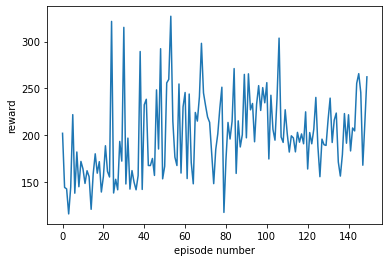

In [40]:
# train!

# settings (temp)          # sooome learning
domain = 'cartpole'
task = 'balance'
batch_size = 1000 * 10     # 1000*10
max_episodes = 150         # 200
seed = 0 # todo
hidden_layers = (24, 24)   # (24, 48)
K_epochs = 8               # 8
minibatch_size = 1024      # 1024
learning_rate = 3e-4       # 3e-4
stds = (2, .5)              # (2, .5)
eps_clip = .2              # .2
gamma = .95                # .99
normalize_returns = True   # True



key = jax.random.PRNGKey(seed)
env = Env(domain, task)
state = env.reset()  # todo: random seed stuff!

policy = ActorCritic(env.state_dim, env.action_dim, std=stds[0], seed=seed,
                     actor_hlayers=hidden_layers, critic_hlayers=hidden_layers)

ppo = PPO(policy, K_epochs=K_epochs, minibatch_size=minibatch_size,
          learning_rate=learning_rate, eps_clip=eps_clip, gamma=gamma,
          normalize_returns=normalize_returns)

update_count, step_count = 0, 0
keys = np.array(jax.random.split(key, num=(max_episodes * env.max_steps)))
total_rewards = []

with trange(max_episodes, desc='Episode') as t:
    for i in t:
        state = env.reset()
        rewards = []
        done = False
        
        while not done:
            action, action_prob = ppo.policy.act(keys[step_count], ppo.policy.params['actor'], state)
            action_squashed = squash_actions(action, env.action_min, env.action_max)
            state_next, reward, done = env.step(action_squashed)
            ppo.add_memory(state, action, reward, action_prob, done)
            state = state_next
            rewards.append(reward)
                
            if ppo.n_memories==batch_size:
                ppo.update(keys[step_count])
                update_count += 1
                ppo.policy.std = stds[0] + (i/max_episodes) * (stds[1]-stds[0])  # reduce exploration noise
        
        step_count += 1
        total_rewards.append(sum(rewards))
        t.set_postfix(total_reward=total_rewards[-1], std=ppo.policy.std, n_updates=update_count)


# plot
plt.plot(total_rewards);
plt.xlabel('episode number');
plt.ylabel('reward');

In [42]:
show_rollout(env, ppo.policy)

# test value function predictions

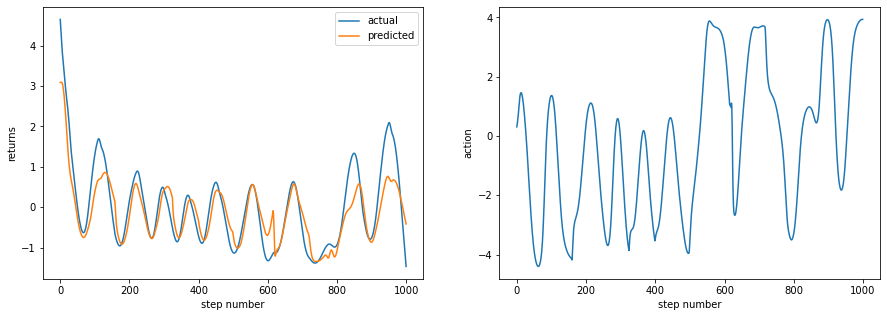

In [41]:
# compare returns to value function predictions
states, is_terminals, rewards, actions = [], [], [], []
state = env.reset()
keys = jax.random.split(key, num=env.max_steps)

# rollout
for i in range(env.max_steps):
    states.append(state)
    action = ppo.policy.act(key, ppo.policy.params['actor'], state)[0]
    state, reward, done = env.step(action)
    rewards.append(reward)
    is_terminals.append(done)
    actions.append(action[0])
actions = np.asarray(actions)

# actual returns
returns, advantages = ppo.get_returns_and_advantages(
    ppo.policy.params['critic'], states, is_terminals, rewards)

# predicted returns
values = ppo.policy.evaluate(ppo.policy.params['critic'], np.array(states))

# plot
ax = plt.subplots(1, 2, figsize=(15,5))[1]
ax[0].plot(returns)
ax[0].plot(values)
ax[0].set(xlabel='step number', ylabel='returns');
ax[0].legend(['actual', 'predicted'])

ax[1].plot(actions);
ax[1].set(xlabel='step number', ylabel='action');

# tests returns and advantages

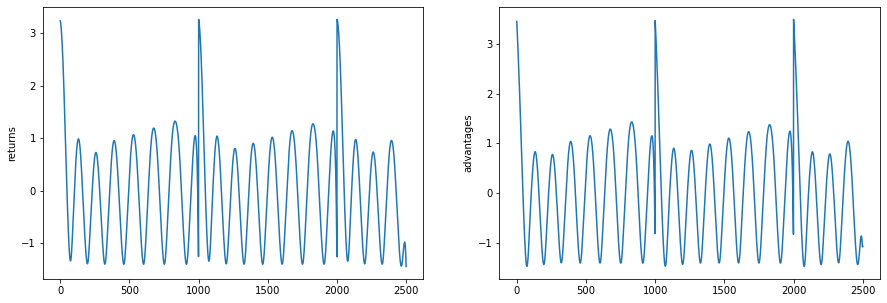

In [44]:
# test return and advantage calculation

# settings
gamma = .9
gae_param = .5
normalize = True

# collect trajectory
key = jax.random.PRNGKey(0)
env = Env('cartpole', 'balance')
policy = ActorCritic(env.state_dim, env.action_dim)
ppo = PPO(policy, gamma=gamma, gae_param=gae_param)
states, is_terminals, rewards = [], [], []


state = env.reset()
keys = jax.random.split(key, num=env.max_steps)
done = False

for i in range(int(env.max_steps*2.5)):
    states.append(state)
    action = ppo.policy.act(key, ppo.policy.params['actor'], state)[0]
    state, reward, done = env.step(action)
    rewards.append(reward)
    is_terminals.append(done)
    
    if done:
        state = env.reset()

returns, advantages = ppo.get_returns_and_advantages(
    ppo.policy.params['critic'], states, is_terminals, rewards, normalize=normalize)

ax = plt.subplots(1, 2, figsize=(15,5))[1]
ax[0].plot(returns);    ax[0].set(ylabel='returns');
ax[1].plot(advantages); ax[1].set(ylabel='advantages');

# test `get_action_probs`

In [235]:
# test get_action_probs
key = jax.random.PRNGKey(seed)
env = Env('point_mass', 'easy')
# env = Env('cartpole', 'balance')
state = env.reset()  # todo: random seed stuff!

policy = ActorCritic(key, env.state_dim, env.action_dim, std=std)
ppo = PPO(policy)
keys = np.array(jax.random.split(key, num=(max_episodes * env.max_steps)))
done = False
state = env.reset()

# fill up buffer
for i in range(env.max_steps):
    action, action_prob = ppo.policy.act(keys[i], ppo.policy.params['actor'], state)
    action_squashed = squash_actions(action, env.action_min, env.action_max)
    state_next, reward, done = env.step(action_squashed)
    ppo.add_memory(state, action, reward, action_prob, done)
    state = state_next

In [238]:
actor_params = ppo.policy.params['actor']
states = np.array(ppo.memory['states'])
actions = np.array(ppo.memory['actions'])

action_means = ppo.policy.actor(actor_params, states)
cov = jnp.diag(jnp.repeat(ppo.policy.std, ppo.policy.action_dim))
action_probs = multivariate_normal.pdf(actions, action_means, cov)

action_means.shape


(1000, 2)